In [1]:
import torch
import cvxpy as cvx
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bound(n_dim,p):

    dx = 0.001
    x = np.arange(0, n_dim,dx)

    cdf = np.cumsum(chi2.pdf(x, df=n_dim)*dx)
    bound = max(x[cdf<=p])

    return bound

In [17]:
n_dim = 100
mu = np.random.rand(n_dim)
A = 0.25 * np.random.rand(n_dim,n_dim) +  0.25 *mu
Corr = np.random.rand(n_dim) 
Corr = np.diag(Corr)

Sigma = A.T @ A 



In [18]:
# eigvals,P = np.linalg.eigh(Sigma)
# D = np.diag(eigvals)
# D_inv = np.diag(1/eigvals)

# Sigma_inv = P.T @ D_inv @ P

# #(P @ D @ P.T) @ (P @ D_inv @ P.T)

# np.max(Sigma - (P @ D @ P.T))


In [19]:
def sparsify_grad(mu,Sigma):


    n_dim = mu.shape[0]
    
    eigvals,P = np.linalg.eigh(Sigma)
    assert (eigvals >= 0).all()

    
    ### Square root of Sigma_inv

    D = np.diag(1/eigvals)
    D_sqrt = np.diag(np.sqrt(1/eigvals))
    P_p = P.T@D_sqrt 

    
    ###################

    C = get_bound(n_dim,p=0.05)

    x = cvx.Variable((n_dim))
    objective = cvx.Minimize(cvx.norm(x,1))
    pb = cvx.Problem(objective,
                    [cvx.sum_squares(P_p@x -P_p@mu) <= C])

    pb.solve(verbose=False)

    rslt = x.value

    assert all(rslt<=mu)

    relative_diff = abs(rslt-mu)/mu

    plt.hist(relative_diff)

    return np.sum(relative_diff>0.9), np.sum(relative_diff<0.1),np.sum(relative_diff<0.5)


(76, 9, 21)

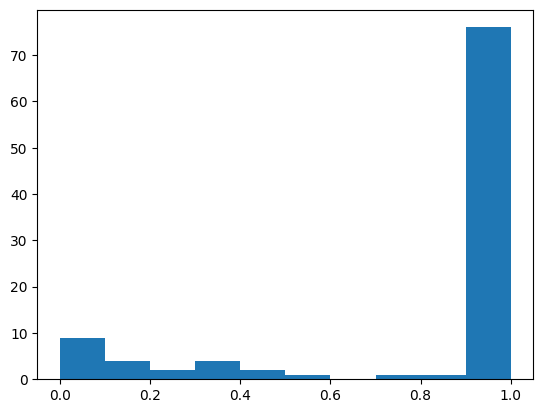

In [20]:
sparsify_grad(mu,Sigma)

In [ ]:
def qcl1(A, b):
    """
    Returns the solution u, z of

        (primal)  minimize    || u ||_1
                  subject to  || A * u - b ||_2  <= 1

        (dual)    maximize    b^T z - ||z||_2
                  subject to  || A'*z ||_inf <= 1.

    Exploits structure, assuming A is m by n with m >= n.
    """

    m, n = A.shape

    # Solve equivalent cone LP with variables x = [u; v].
    #
    #     minimize    [0; 1]' * x
    #     subject to  [ I  -I ] * x <=  [  0 ]   (componentwise)
    #                 [-I  -I ] * x <=  [  0 ]   (componentwise)
    #                 [ 0   0 ] * x <=  [  1 ]   (SOC)
    #                 [-A   0 ]         [ -b ]
    #
    #     maximize    -t + b' * w
    #     subject to  z1 - z2 = A'*w
    #                 z1 + z2 = 1
    #                 z1 >= 0,  z2 >=0,  ||w||_2 <= t.

    c = matrix(n*[0.0] + n*[1.0])
    h = matrix( 0.0, (2*n + m + 1, 1))
    h[2*n] = 1.0
    h[2*n+1:] = -b

    def G(x, y, alpha = 1.0, beta = 0.0, trans = 'N'):
        y *= beta
        if trans=='N':
            # y += alpha * G * x
            y[:n] += alpha * (x[:n] - x[n:2*n])
            y[n:2*n] += alpha * (-x[:n] - x[n:2*n])
            y[2*n+1:] -= alpha * A*x[:n]

        else:
            # y += alpha * G'*x
            y[:n] += alpha * (x[:n] - x[n:2*n] - A.T * x[-m:])
            y[n:] -= alpha * (x[:n] + x[n:2*n])


    def Fkkt(W):
        """
        Returns a function f(x, y, z) that solves

            [ 0   G'   ] [ x ] = [ bx ]
            [ G  -W'*W ] [ z ]   [ bz ].
        """

        # First factor
        #
        #     S = G' * W**-1 * W**-T * G
        #       = [0; -A]' * W3^-2 * [0; -A] + 4 * (W1**2 + W2**2)**-1
        #
        # where
        #
        #     W1 = diag(d1) with d1 = W['d'][:n] = 1 ./ W['di'][:n]
        #     W2 = diag(d2) with d2 = W['d'][n:] = 1 ./ W['di'][n:]
        #     W3 = beta * (2*v*v' - J),  W3^-1 = 1/beta * (2*J*v*v'*J - J)
        #        with beta = W['beta'][0], v = W['v'][0], J = [1, 0; 0, -I].

        # As = W3^-1 * [ 0 ; -A ] = 1/beta * ( 2*J*v * v' - I ) * [0; A]
        beta, v = W['beta'][0], W['v'][0]
        As = 2 * v * (v[1:].T * A)
        As[1:,:] *= -1.0
        As[1:,:] -= A
        As /= beta

        # S = As'*As + 4 * (W1**2 + W2**2)**-1
        S = As.T * As
        d1, d2 = W['d'][:n], W['d'][n:]
        d = 4.0 * (d1**2 + d2**2)**-1
        S[::n+1] += d
        lapack.potrf(S)

        def f(x, y, z):

            # z := - W**-T * z
            z[:n] = -div( z[:n], d1 )
            z[n:2*n] = -div( z[n:2*n], d2 )
            z[2*n:] -= 2.0*v*( v[0]*z[2*n] - blas.dot(v[1:], z[2*n+1:]) )
            z[2*n+1:] *= -1.0
            z[2*n:] /= beta

            # x := x - G' * W**-1 * z
            x[:n] -= div(z[:n], d1) - div(z[n:2*n], d2) + As.T * z[-(m+1):]
            x[n:] += div(z[:n], d1) + div(z[n:2*n], d2)

            # Solve for x[:n]:
            #
            #    S*x[:n] = x[:n] - (W1**2 - W2**2)(W1**2 + W2**2)^-1 * x[n:]

            x[:n] -= mul( div(d1**2 - d2**2, d1**2 + d2**2), x[n:])
            lapack.potrs(S, x)

            # Solve for x[n:]:
            #
            #    (d1**-2 + d2**-2) * x[n:] = x[n:] + (d1**-2 - d2**-2)*x[:n]

            x[n:] += mul( d1**-2 - d2**-2, x[:n])
            x[n:] = div( x[n:], d1**-2 + d2**-2)

            # z := z + W^-T * G*x
            z[:n] += div( x[:n] - x[n:2*n], d1)
            z[n:2*n] += div( -x[:n] - x[n:2*n], d2)
            z[2*n:] += As*x[:n]

        return f

    dims = {'l': 2*n, 'q': [m+1], 's': []}
    sol = solvers.conelp(c, G, h, dims, kktsolver = Fkkt)
    if sol['status'] == 'optimal':
        return sol['x'][:n],  sol['z'][-m:]
    else:
        return None, None


In [ ]:
n_dim = P.shape
mu = np.ones(n_dim)
A = P @ D_sqrt
b = A@mu
C = 10
A,b = A/np.sqrt(C), b/np.sqrt(C)


qcl1(A,b)

NameError: name 'matrix' is not defined

256